# Analyzing some DECam images with starlink streaks

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

from astropy import coordinates as coord
from astropy.time import Time
import astropy.units as u
from astropy.visualization import ZScaleInterval, SqrtStretch, ImageNormalize
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import lsst.daf.persistence as dafPersist
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

### Use the butler to access a processed visit image and corresponding source catalog for one image
Note: this notebook runs on data that is on lsst-dev at present, not epyc

In [17]:
repo = '/project/mrawls/starlink/rerun/20200317'
butler = dafPersist.Butler(repo)

In [208]:
dataId = {'visit': 941420, 'ccd': 7}
calexp = butler.get('calexp', dataId=dataId)
src = butler.get('src', dataId=dataId)
psfRadius = calexp.getPsf().computeShape().getDeterminantRadius()

In [265]:
print(psfRadius)

2.1748135453331696


<IPython.core.display.Javascript object>


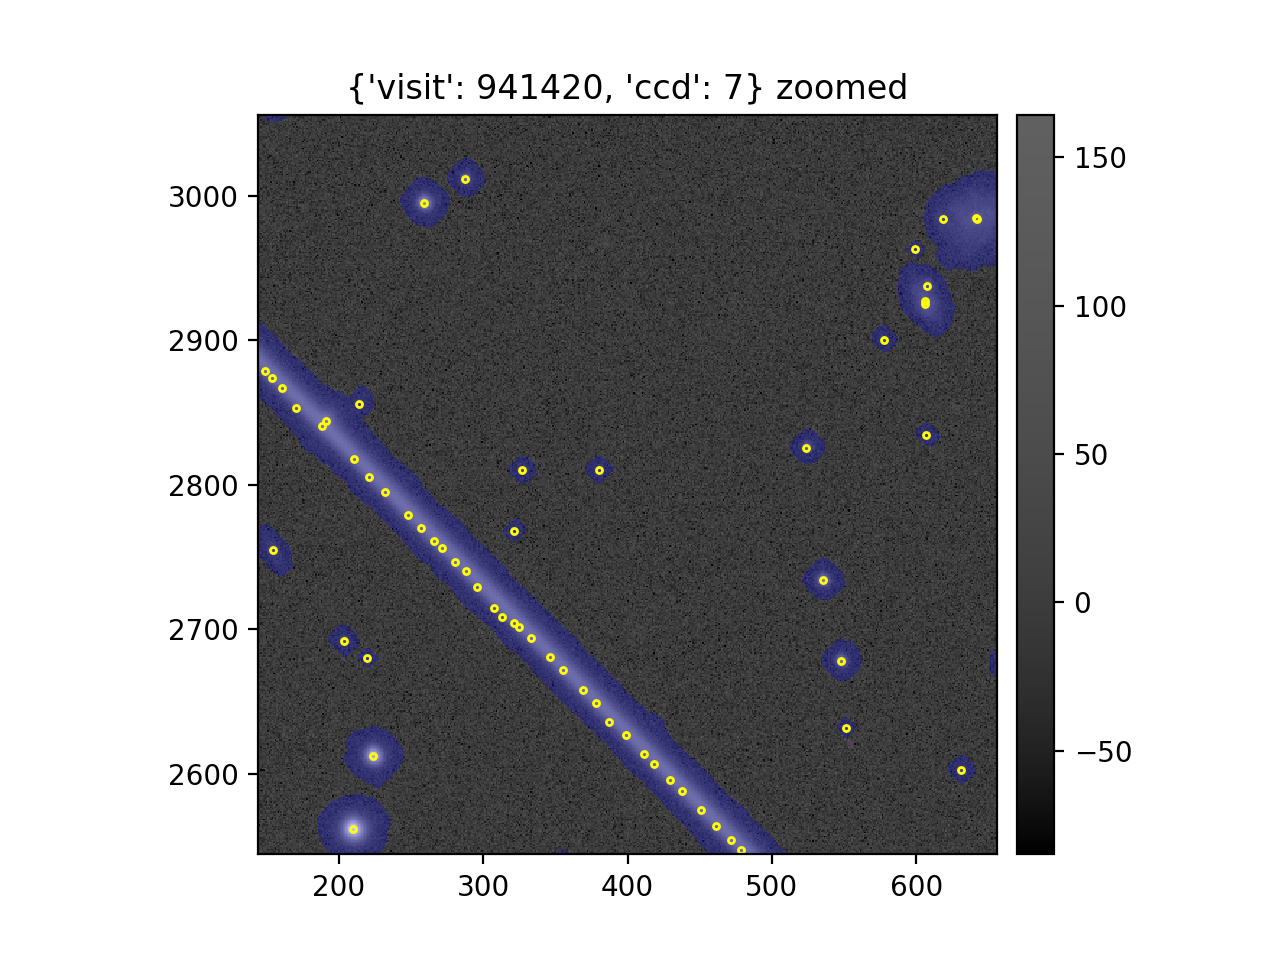

In [209]:
disp1 = afwDisplay.Display(1)
disp1.scale("asinh", "zscale", Q=8)
disp1.mtv(calexp, title=str(dataId) + ' zoomed')
disp1.zoom(8)
disp1.pan(400, 2800)
plt.plot(src['slot_Centroid_x'], src['slot_Centroid_y'], marker='o',
         mfc='None', ls='None', ms=psfRadius, color='yellow')
#disp1.dot('o', 450, 2750, size=psfRadius)  # another way to plot a dot

The satellite trail is masked as detected (blue). All the sources from the source catalog are plotted as open yellow circles sized to the image's PSF.

In [22]:
photoCalib = calexp.getPhotoCalib()
njyImage = photoCalib.calibrateImage(calexp.maskedImage)

All pixels in njyImage have values that correspond to their calibrated flux in nJy.

Similarly, we can make a flux calibrated catalog, with new `_flux`, `_fluxErr`, `_mag`, and `_magErr` fields.

In [26]:
calibratedCatalog = photoCalib.calibrateCatalog(src)

In [243]:
pixelScale = calexp.getWcs().getPixelScale()
pixelScale.asArcseconds()  # arcsec per pixel

0.2626266207112311

In [242]:
(psfRadius*pixelScale).asArcseconds()

0.5711639320878621

### Use visit info to compute sun location and phase angle

In [240]:
visitInfo = calexp.getInfo().getVisitInfo()
print(visitInfo.getBoresightAzAlt())
print(visitInfo.getBoresightRaDec())

(312.320400, +77.250000)
(84.201445, -21.204939)


In [241]:
boresight_raDec = visitInfo.getBoresightRaDec()

In [212]:
dateObs = visitInfo.getDate().toPython()

In [239]:
dateObsAstropy = Time(dateObs)
sky_coord = coord.SkyCoord(boresight_raDec.getRa().asDegrees()*u.deg, boresight_raDec.getDec().asDegrees()*u.deg)
location = coord.EarthLocation.of_site('Cerro Tololo Interamerican Observatory')
aa_frame = coord.AltAz(obstime=dateObsAstropy, location=location)
aa_coord = sky_coord.transform_to(aa_frame)
sun_coord = coord.get_sun(dateObsAstropy)
sun_aa = sun_coord.transform_to(aa_frame)

print('sun location: \n', sun_coord, sun_aa)
print('')
print('phase angle: \n', skyCoord.separation(sun_coord))

sun location: 
 <SkyCoord (GCRS: obstime=2020-03-06 00:05:52.410235, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec, distance) in (deg, deg, AU)
    (346.74903321, -5.67467956, 0.99206062)> <SkyCoord (AltAz: obstime=2020-03-06 00:05:52.410235, location=(1814303.74553723, -5214365.7436216, -3187340.56598756) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt, distance) in (deg, deg, m)
    (255.95285985, -12.40682634, 1.48411531e+11)>

phase angle: 
 56d11m27.2026s


### Rotate image so the streak is horizontal and we can plot the brightness profile
This is a clunky way to guesstimate how much to rotate the image by

In [92]:
coordUL = [153.2, 2879.2]  # 1 point from upper left of line, manually measured
coordLR = [1970.7, 1036.3]  # another point from lower right of line, manually measured
angle = np.arctan2(coordLR[1] - coordUL[1], coordLR[0] - coordUL[0]) * u.rad  # angle by which to rotate image
angle.to(u.deg)

<Quantity -45.39757662 deg>

Verify the line is roughly correct

<IPython.core.display.Javascript object>


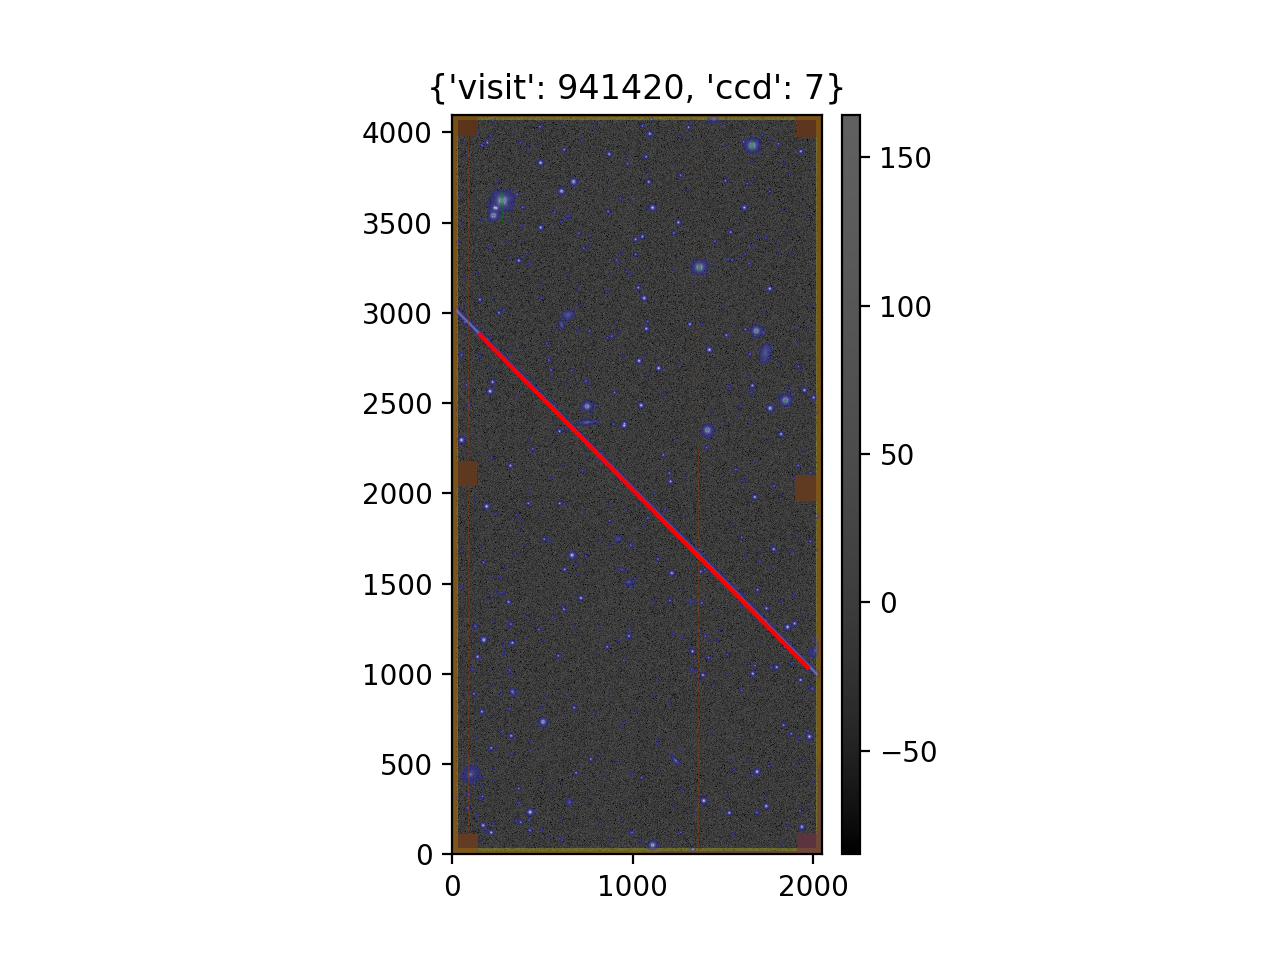

In [245]:
disp2 = afwDisplay.Display(2)
disp2.scale("asinh", "zscale", Q=8)
disp2.mtv(calexp, title=str(dataId))
plt.plot([coordUL[0], coordLR[0]], [coordUL[1], coordLR[1]], c='red')

### We now leave afw-land and work with a numpy image array

In [246]:
imageArray = njyImage.getImage().getArray()  # remember, the pixel values are real nJy! yay!

<IPython.core.display.Javascript object>


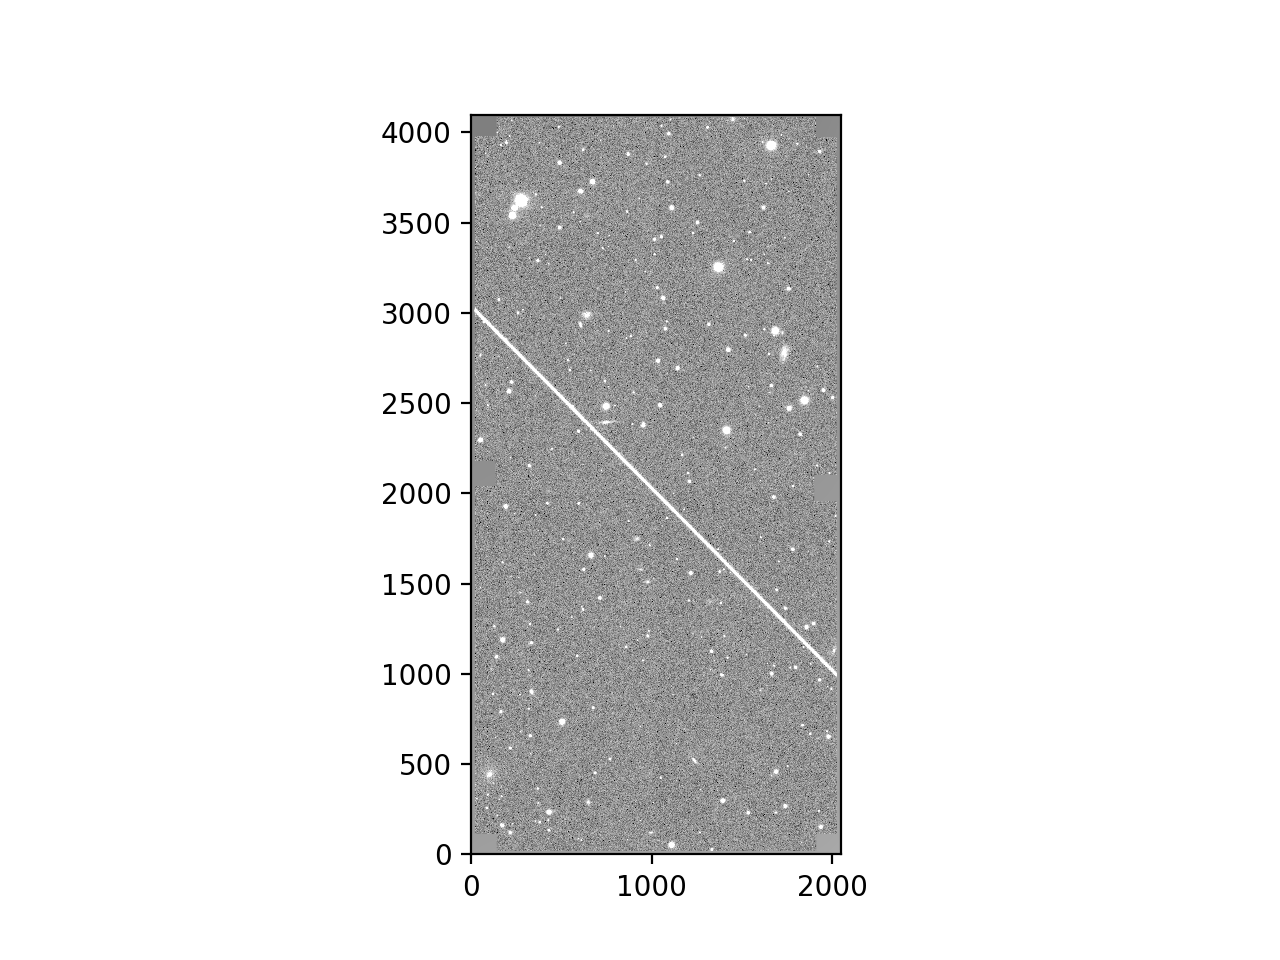

In [148]:
plt.figure()
norm = ImageNormalize(imageArray, interval=ZScaleInterval(), stretch=SqrtStretch())
plt.imshow(imageArray, cmap='gray', norm=norm, origin='lower')

In [149]:
rotatedArray = rotate(imageArray, angle)

<IPython.core.display.Javascript object>


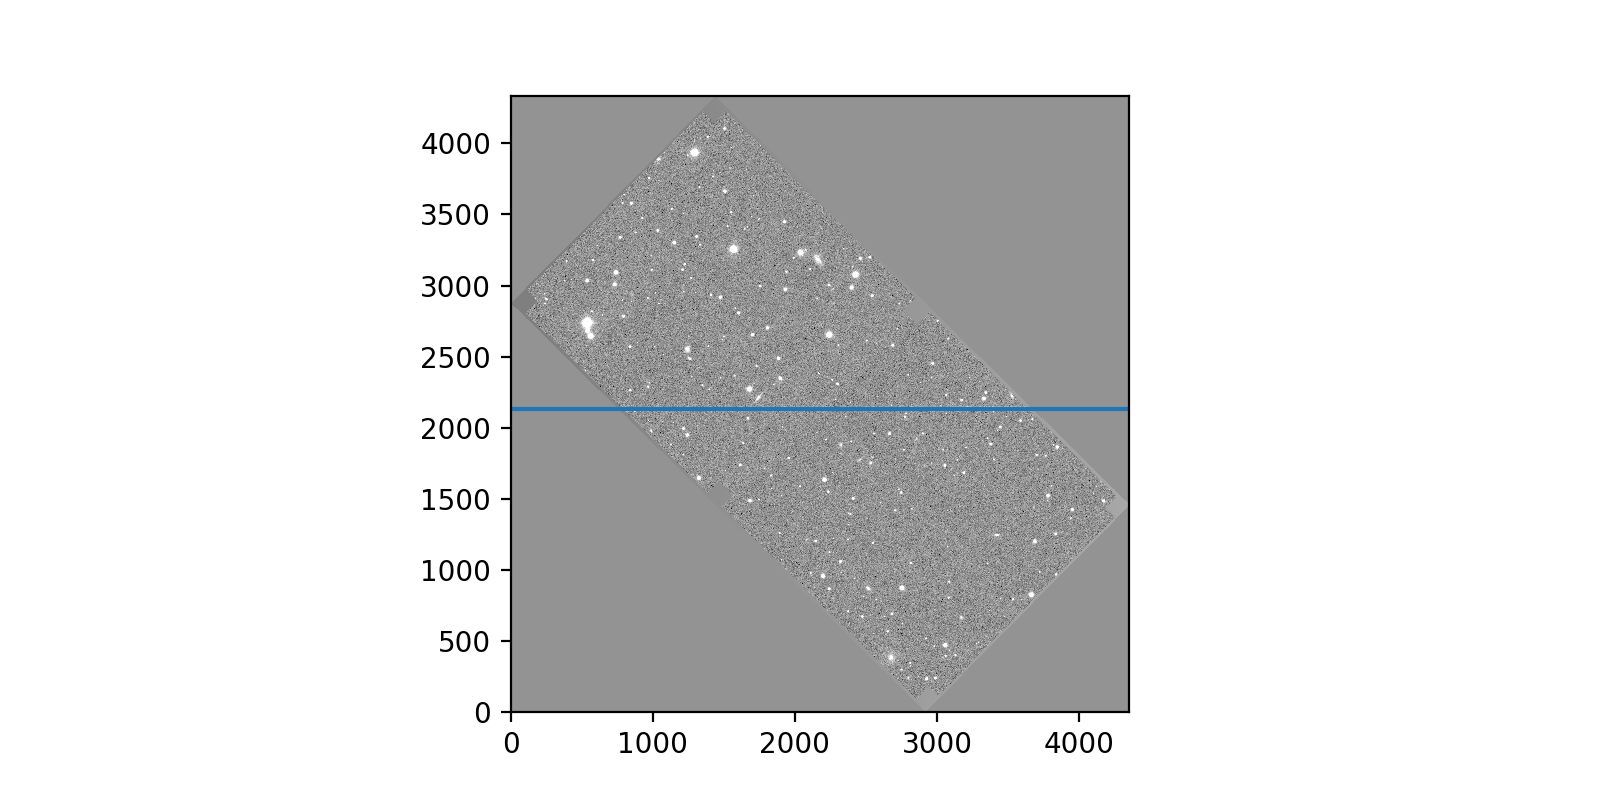

In [266]:
plt.figure(figsize=(8,4))
plt.imshow(rotatedArray, cmap='gray', norm=norm, origin='lower')
#plt.gca().set_xlim([500, 4000])
#plt.gca().set_ylim([1500, 2500])
plt.axhline(y=2134)

### Plot the line profile
Close, but not perfect

In [247]:
y_trail = 2134  # y-value location of trail in rotated image
y_width = 20  # pixel width of trail
x_start = 1100
x_end = 3500
x_length = x_end - x_start
sliced = rotatedArray[y_trail - y_width:y_trail + width, x_start:x_end]

<IPython.core.display.Javascript object>


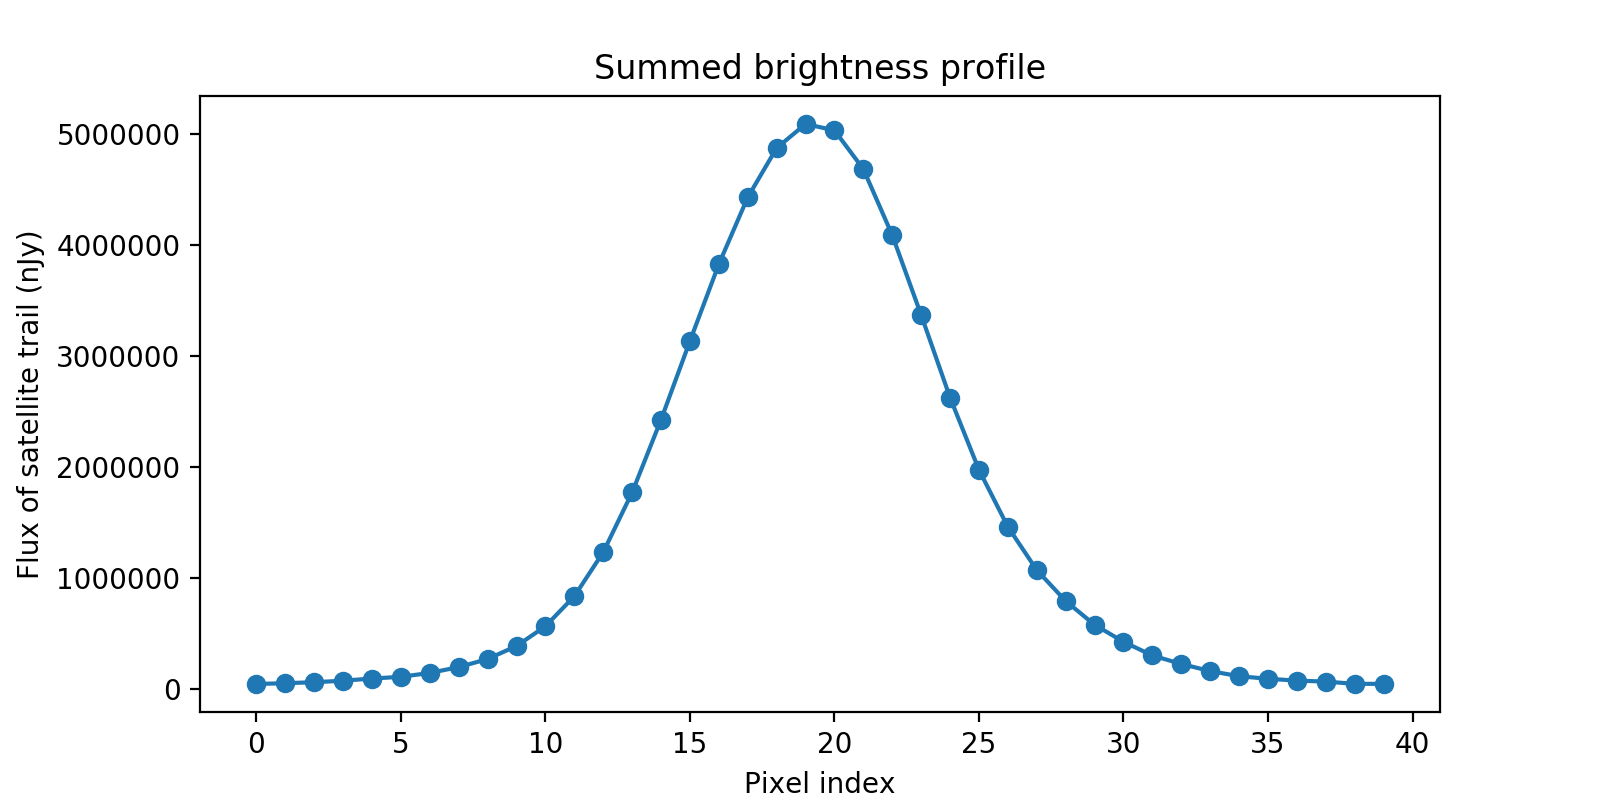

Text(0.5, 1.0, 'Summed brightness profile')

In [263]:
fig = plt.figure(figsize=(8, 4))
ax = fig.subplots()
ax.plot(sliced.sum(axis=1), marker='o')
plt.xlabel('Pixel index')
plt.ylabel('Flux of satellite trail (nJy)')
plt.title('Summed brightness profile')

<IPython.core.display.Javascript object>


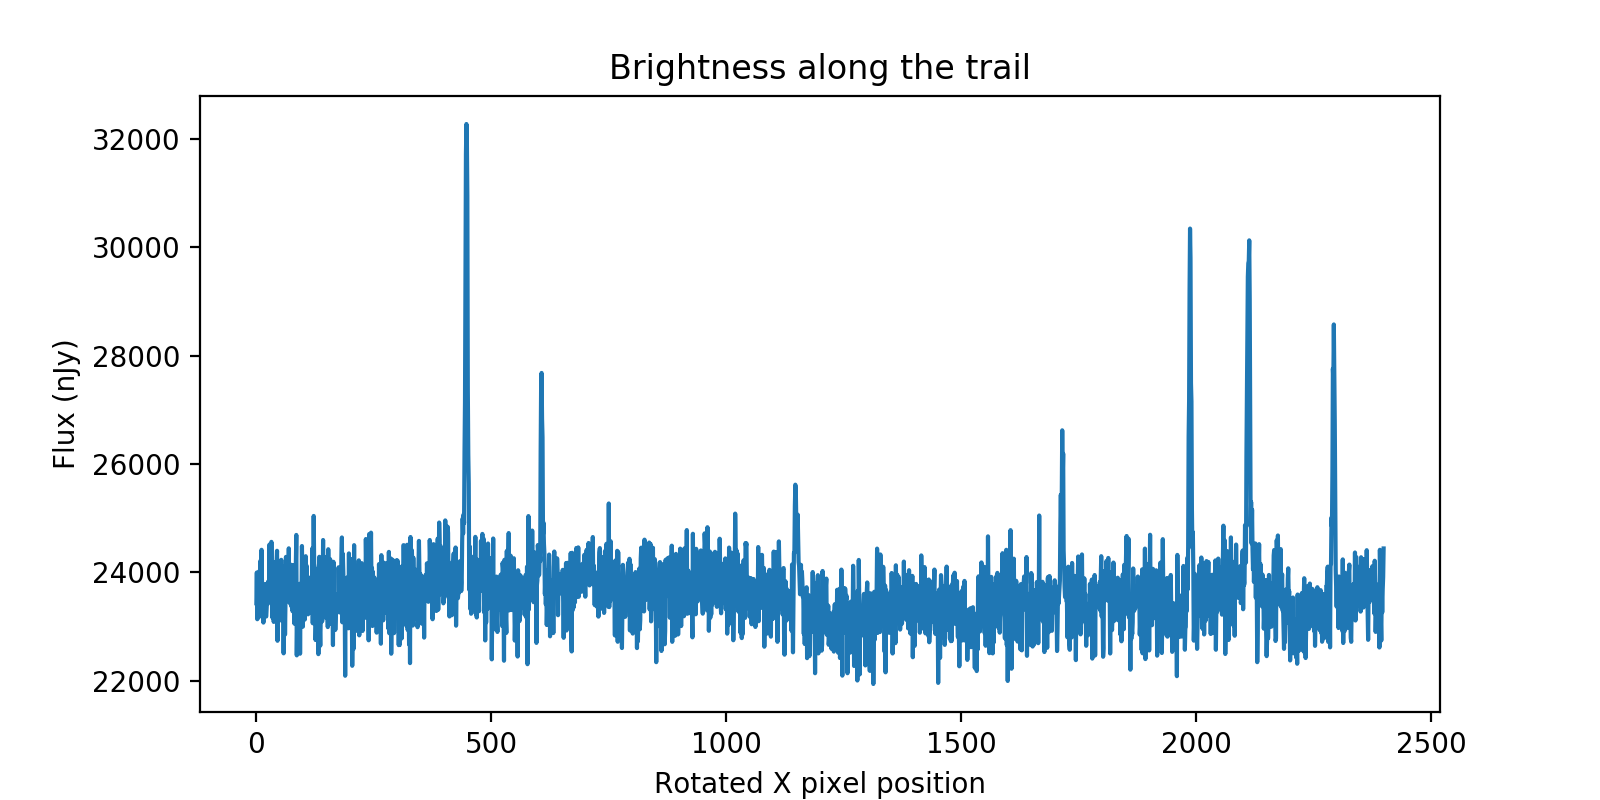

Text(0, 0.5, 'Flux (nJy)')

In [400]:
fig = plt.figure(figsize=(8,4))
ax = fig.subplots()
ax.plot(sliced.sum(axis=0))
plt.title('Brightness along the trail')
plt.xlabel('Rotated X pixel position')
plt.ylabel('Flux (nJy)')
#ax.set_ylim(8500, 10000)

### WIP: something meaningful in magnitudes per arcsec^2?
Extended sources are hard

In [171]:
numerator = (sliced.sum()*u.nJy).to(u.ABmag).value  # magnitude of a chunk of the trail

In [321]:
denominator = y_width*x_length * pixelScale.asArcseconds()**2  # area of the chunk of the trail in arcsec^2

In [322]:
print(numerator)
print(denominator)
numerator/denominator  # I think ?

12.015552637262841
3310.69161149764


0.003629317993718971

## Turn most of the work above into a function

In [8]:
def starlinkAnalyze(repo, dataId, trailPoint1, trailPoint2, trailWidth=20, nudge=0):
    """Analyze an image processed with the LSST Science Pipelines containing a satellite trail.
    
    Parameters
    ----------
    repo : `str`
        Butler repository, probably a file path
    dataId : `dict`-like
        Butler Data ID to retrieve exposure
        e.g., {'visit': 12345, 'ccd': 42}
    trailPoint1 : `list` with 2 values
        [x1, y1] coordinates of first point on trail, in pixels
    trailPoint2 : `list` with 2 values
        [x2, y2] coordinates of second point on trail, in pixels
    trailWidth : `int`
        Approximate half-width of satellite trail, in pixels, optional
        Default is 20
    nudge : `int`
        Amount by which to adjust the y-value of the middle of the satellite trail, optional
        Default is 0

    Returns
    -------
    sun_coord : `astropy.coordinates.SkyCoord`
        Location of the Sun when the image was taken
    sun_aa : `astropy.coordinates.SkyCoord`
        Altitude and azimuth of the Sun when the image was taken
    phase_angle : `astropy.coordinates.Angle`
        Angle between the satellite's line of sight toward the Sun
        and the line of sight toward the observatory on Earth
    rotatedArray : `numpy.array`
        Image array that has been rotated so the satellite trail is horizontal

    Notes
    -----
    For best results, display or plot the image beforehand,
    and manually choose trailPoint1 and trailPoint2 so they are
    at opposite ends of the satellite trail.
        
    """
    # Load data
    butler = dafPersist.Butler(repo)
    calexp = butler.get('calexp', dataId=dataId)
    #src = butler.get('src', dataId=dataId)
    psfRadius = calexp.getPsf().computeShape().getDeterminantRadius()
    photoCalib = calexp.getPhotoCalib()
    njyImage = photoCalib.calibrateImage(calexp.maskedImage)
    #calibratedCatalog = photoCalib.calibrateCatalog(src)
    pixelScale = calexp.getWcs().getPixelScale()
    
    # Get sun location and phase angle
    visitInfo = calexp.getInfo().getVisitInfo()
    boresight_raDec = visitInfo.getBoresightRaDec()
    dateObs = visitInfo.getDate().toPython()
    dateObsAstropy = Time(dateObs)
    sky_coord = coord.SkyCoord(boresight_raDec.getRa().asDegrees()*u.deg, boresight_raDec.getDec().asDegrees()*u.deg)
    location = coord.EarthLocation.of_site('Cerro Tololo Interamerican Observatory')
    aa_frame = coord.AltAz(obstime=dateObsAstropy, location=location)
    aa_coord = sky_coord.transform_to(aa_frame)
    sun_coord = coord.get_sun(dateObsAstropy)
    sun_aa = sun_coord.transform_to(aa_frame)
    phase_angle = sky_coord.separation(sun_coord)
    
    # Rotate image data and do geometry
    angle = np.arctan2(trailPoint2[1] - trailPoint1[1], trailPoint2[0] - trailPoint1[0]) * u.rad
    slope = (trailPoint2[1] - trailPoint1[1])/(trailPoint2[0] - trailPoint1[0])
    imageArray = njyImage.getImage().getArray()
    xmax = len(imageArray[0])
    ymax = len(imageArray)
    rotatedArray = rotate(imageArray, angle)
    trailRotY = int(xmax * np.sin(np.abs(angle)) + (xmax*slope + (ymax - trailPoint2[1])) * np.cos(np.abs(angle)))
    trailRotY = trailRotY + nudge
    x_length = trailPoint2[0] - trailPoint1[0]
    x_start = int(trailPoint1[0])
    x_end = int(trailPoint2[0])
    trailRotX = int((ymax - (trailPoint1[1] - trailPoint1[0]*slope)) * np.tan(np.abs(angle)))
    sliced = rotatedArray[trailRotY - trailWidth:trailRotY + trailWidth, x_start + trailRotX:x_end + trailRotX]
    
    # Make plots of satellite trail
    fig1 = plt.figure(figsize=(6, 6))
    norm = ImageNormalize(rotatedArray, interval=ZScaleInterval(), stretch=SqrtStretch())
    plt.imshow(rotatedArray, cmap='gray', norm=norm, origin='lower')
    plt.axhline(y=trailRotY - trailWidth, ls=':', color='C1', lw=2)
    plt.axhline(y=trailRotY + trailWidth, ls=':', color='C1', lw=2)
    plt.axhline(y=trailRotY, ls=':', color='C0', lw=2)
    plt.title('Rotated image with horizontal satellite trail')
    
    fig2 = plt.figure(figsize=(8, 4))
    ax2 = fig2.subplots()
    ax2.plot(sliced.sum(axis=1), marker='o')
    plt.xlabel('Pixel index')
    plt.ylabel('Flux (nJy)')
    plt.title('Summed flux profile')
    
    fig3 = plt.figure(figsize=(8, 4))
    ax3 = fig3.subplots()
    ax3.plot(sliced.sum(axis=0))
    plt.xlabel('Rotated X pixel position')
    plt.ylabel('Flux (nJy)')
    plt.title('Flux along the trail')
    
    return sun_coord, sun_aa, phase_angle, rotatedArray

<IPython.core.display.Javascript object>


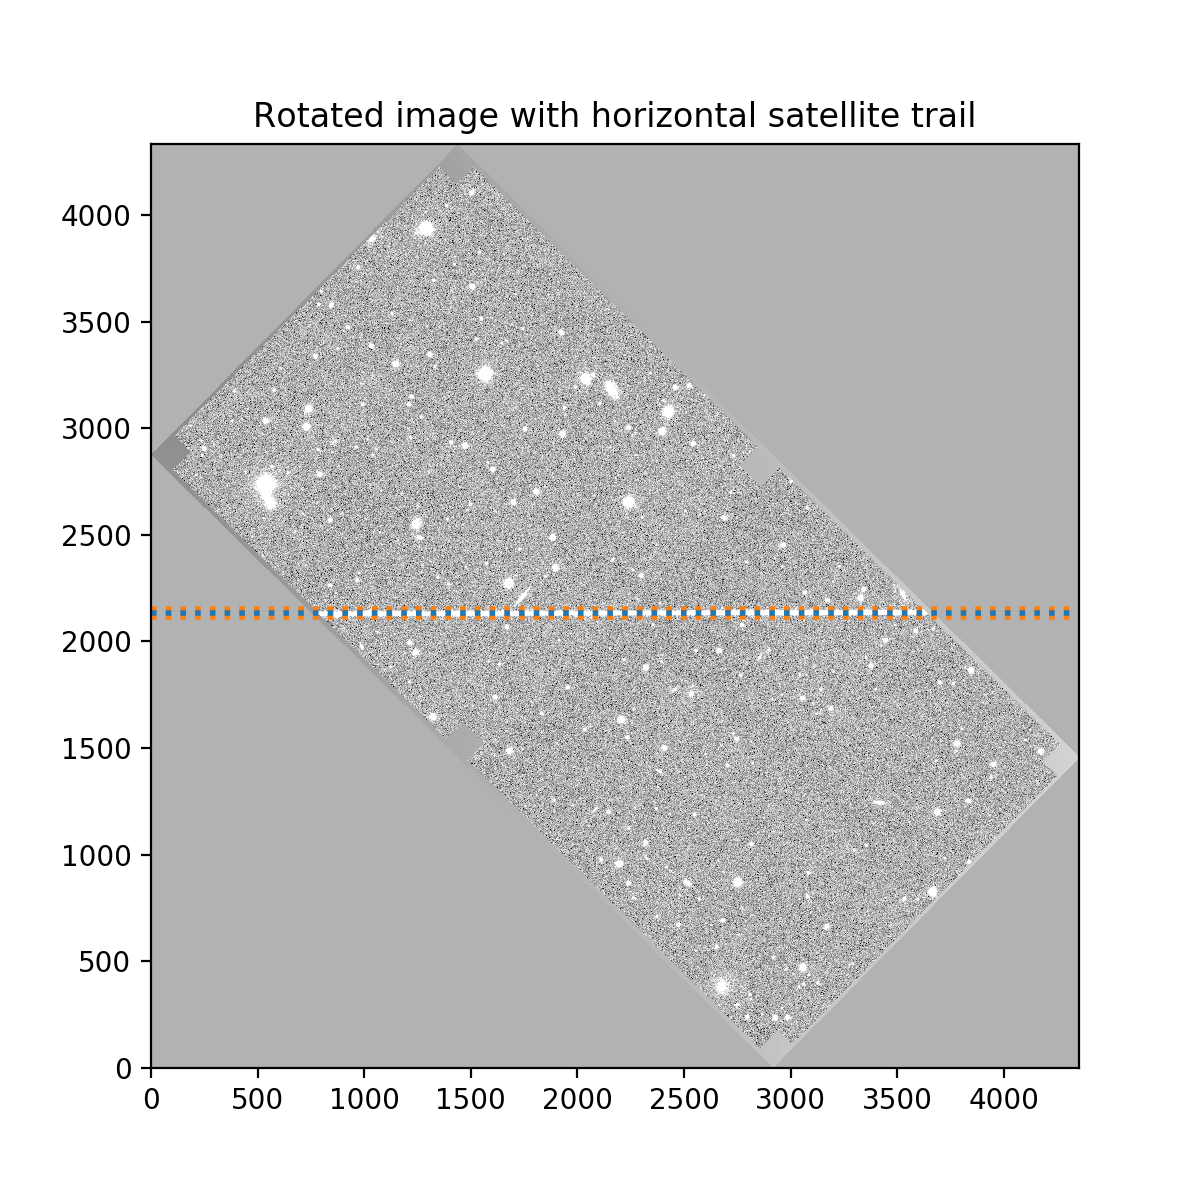

<IPython.core.display.Javascript object>


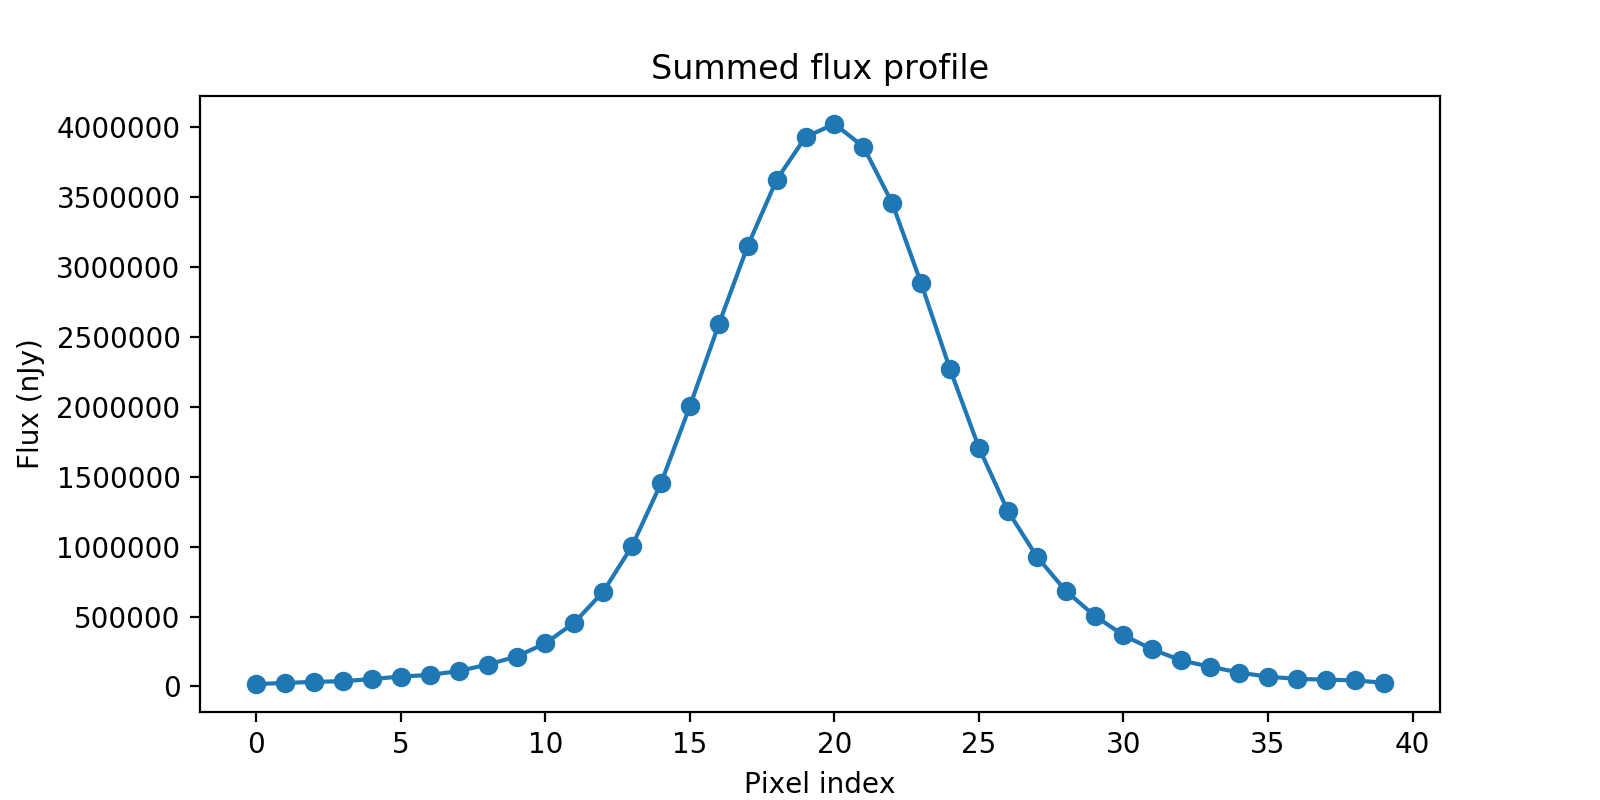

<IPython.core.display.Javascript object>


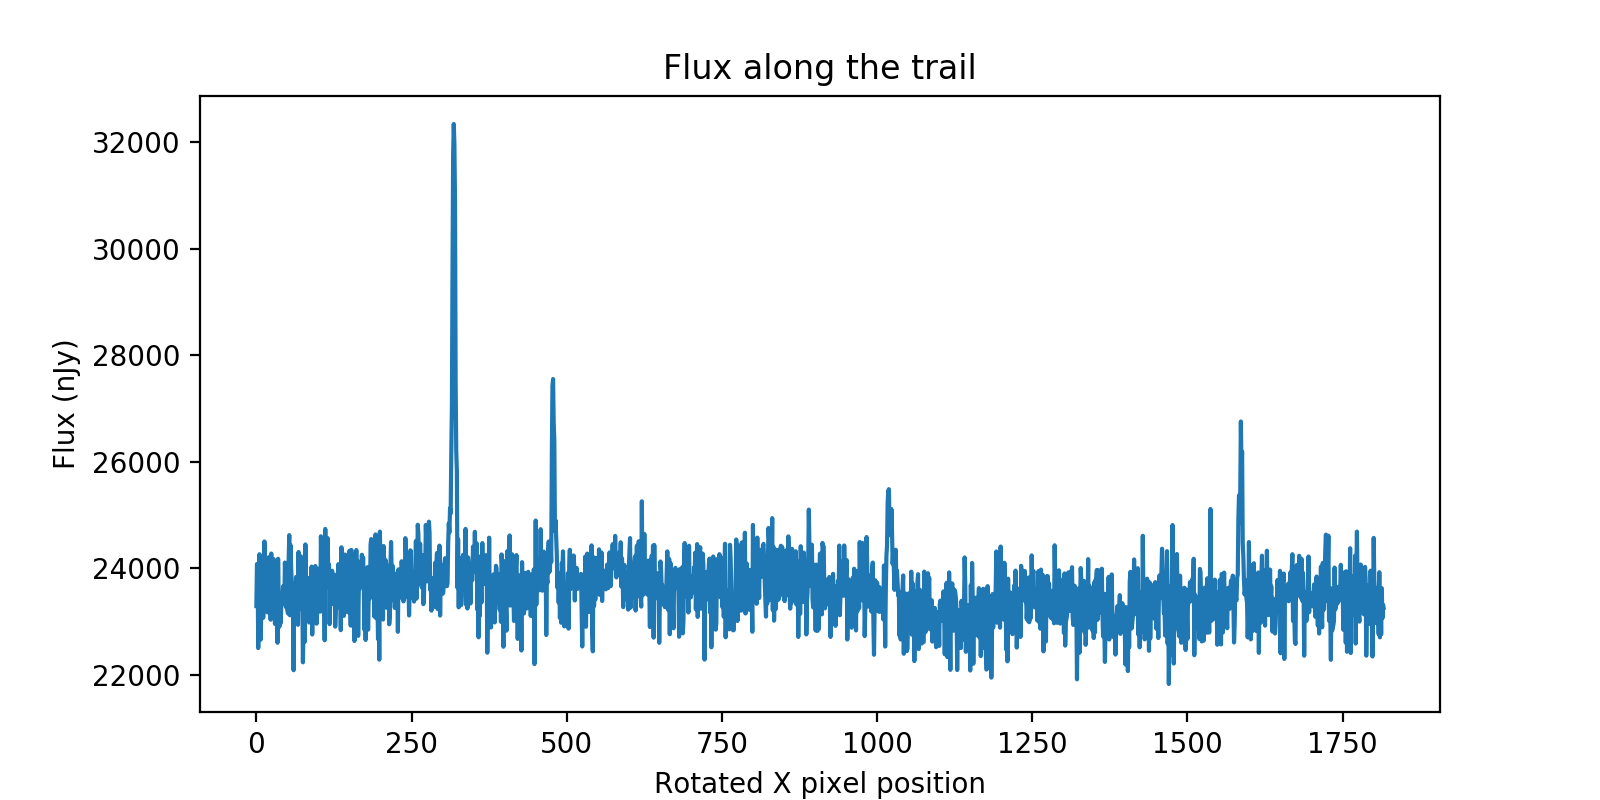

In [9]:
repo = '/project/mrawls/starlink/rerun/20200317'
dataId = {'visit': 941420, 'ccd': 7}
trailPoint1 = [153.2, 2879.2]
trailPoint2 = [1970.7, 1036.3]
results = starlinkAnalyze(repo, dataId, trailPoint1, trailPoint2, trailWidth=20, nudge=-15)

In [429]:
dataId = {'visit': 941422, 'ccd': 33}
calexp = butler.get('calexp', dataId=dataId)
src = butler.get('src', dataId=dataId)

<IPython.core.display.Javascript object>


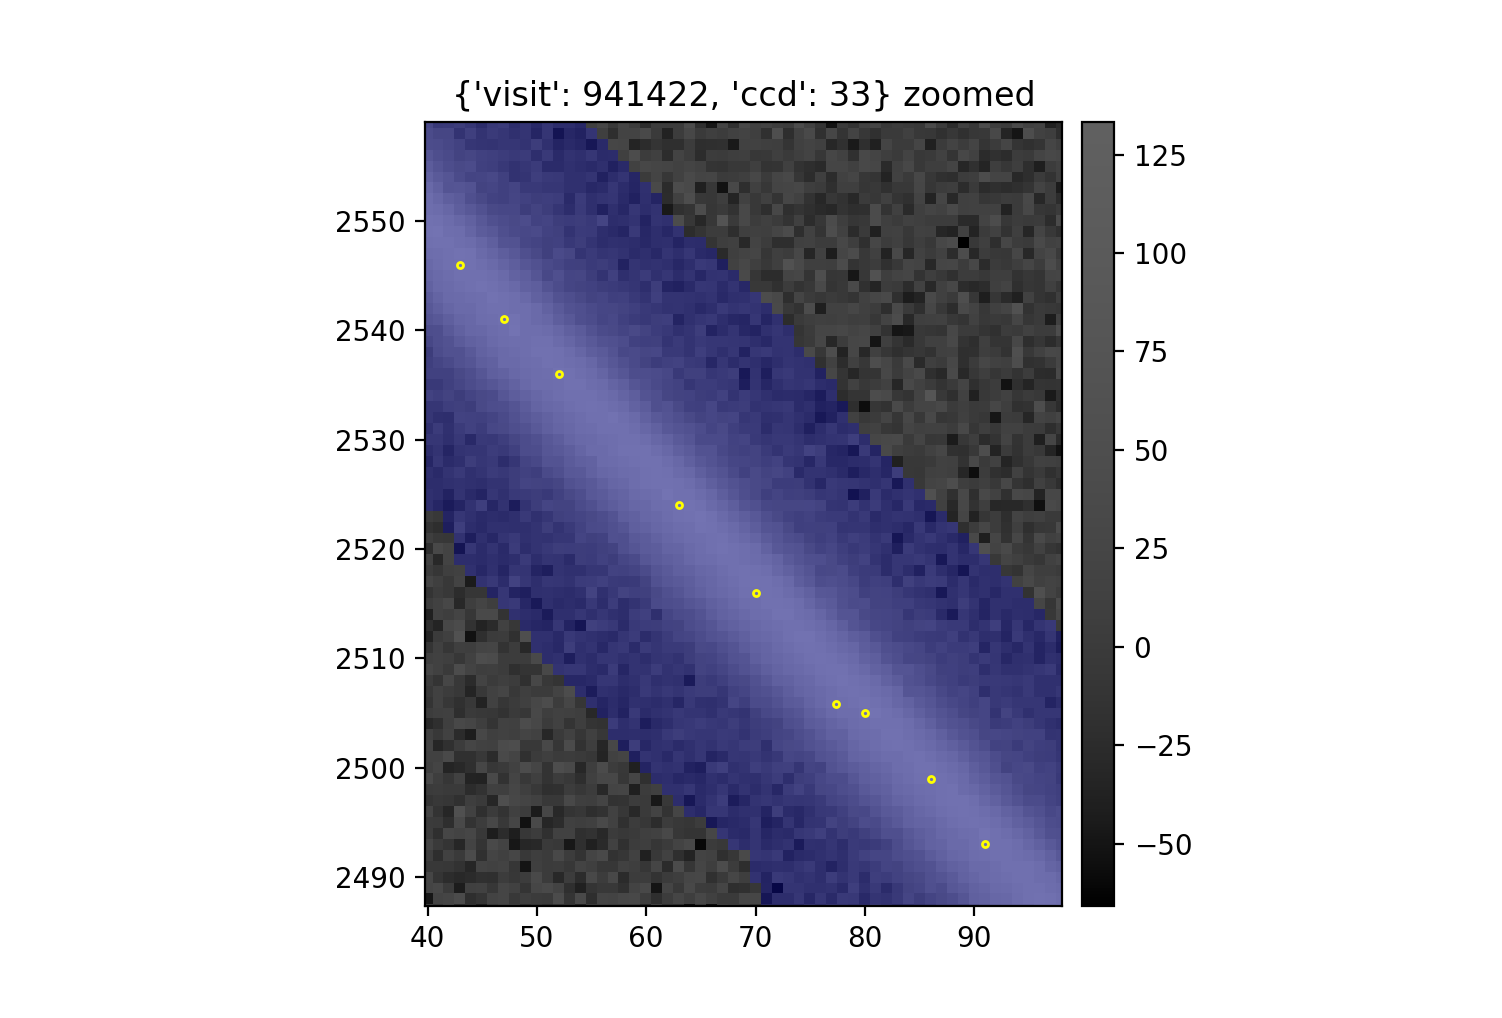

In [431]:
psfRadius = calexp.getPsf().computeShape().getDeterminantRadius()
disp1 = afwDisplay.Display(30)
disp1.scale("asinh", "zscale", Q=8)
disp1.mtv(calexp, title=str(dataId) + ' zoomed')
#disp1.zoom(8)
#disp1.pan(400, 2800)
plt.plot(src['slot_Centroid_x'], src['slot_Centroid_y'], marker='o',
         mfc='None', ls='None', ms=psfRadius, color='yellow')

<IPython.core.display.Javascript object>


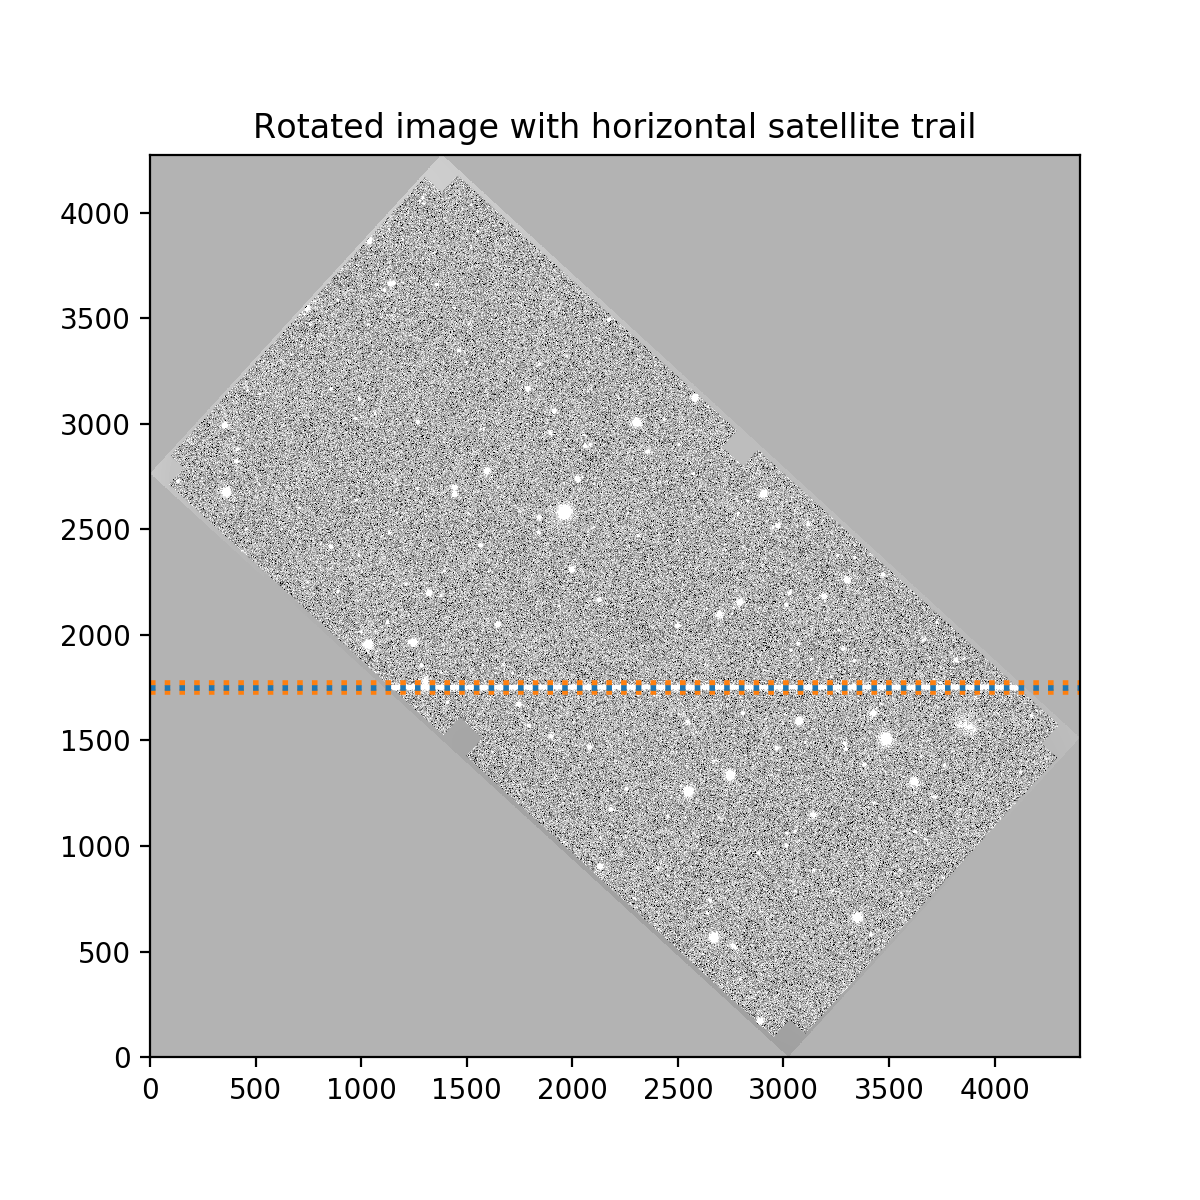

<IPython.core.display.Javascript object>


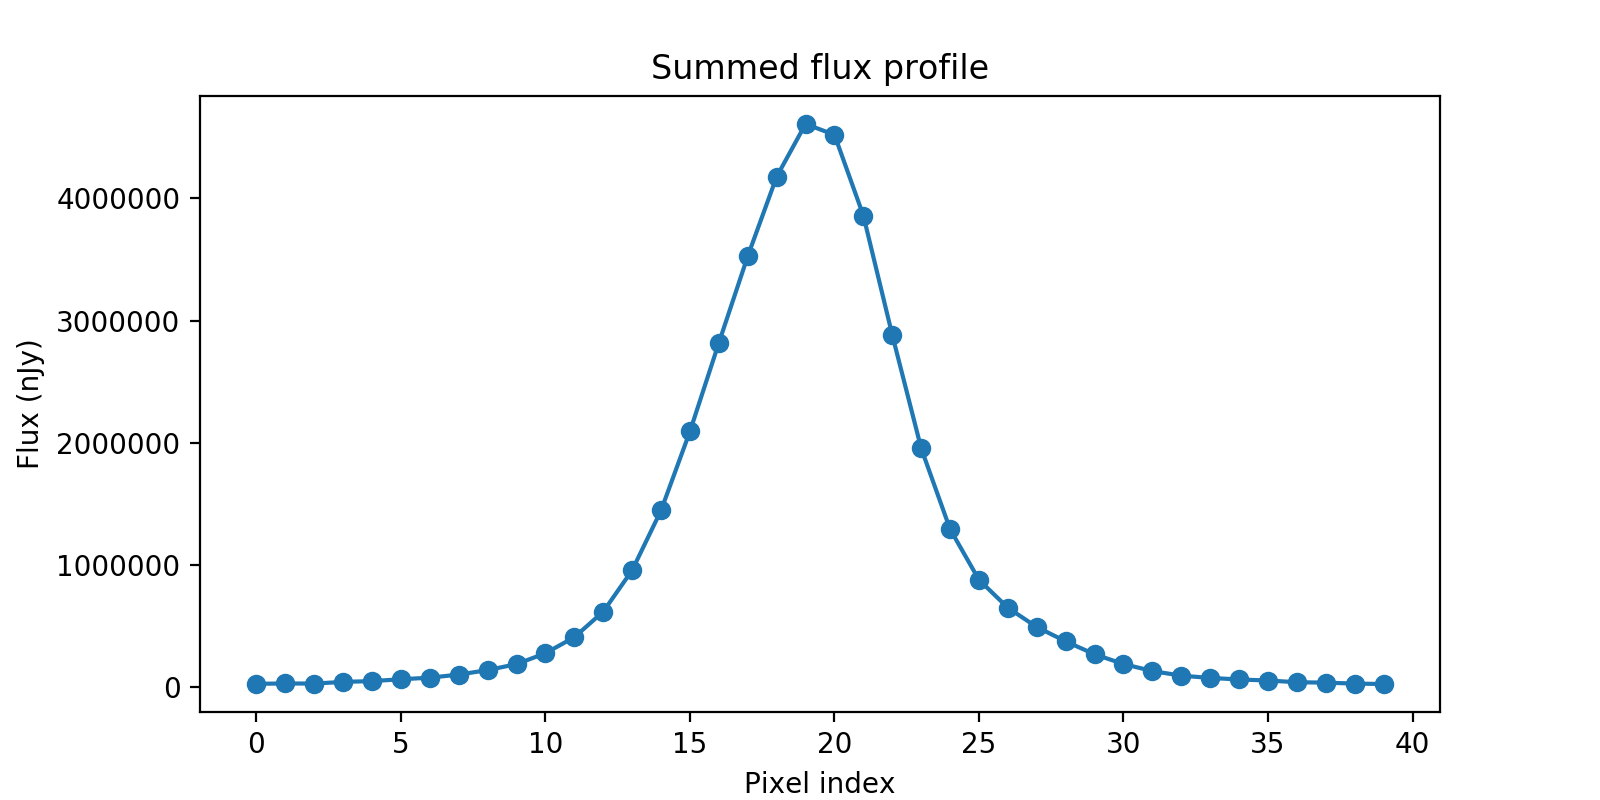

<IPython.core.display.Javascript object>


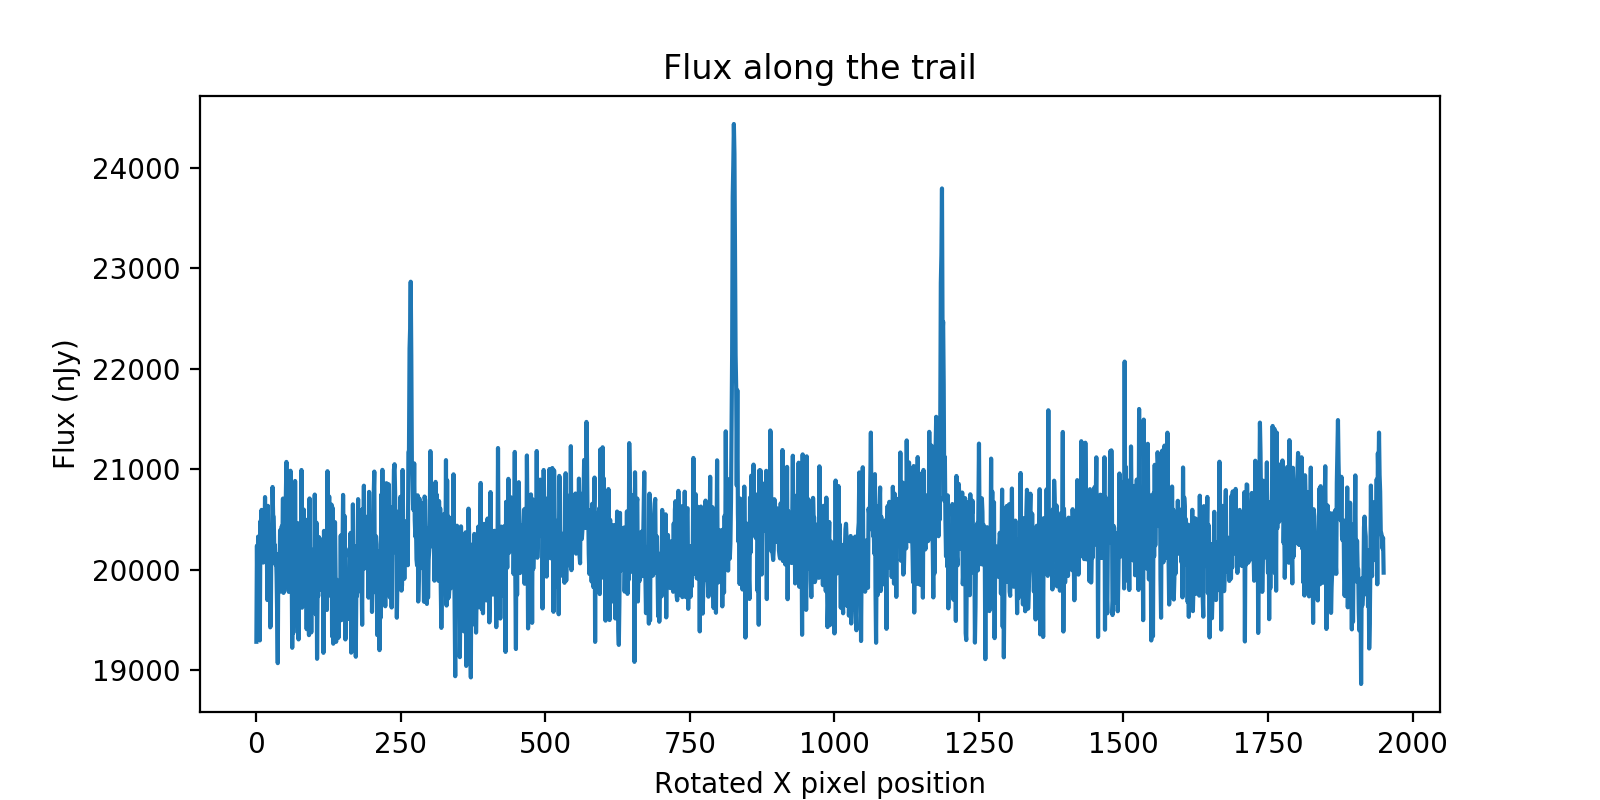

In [15]:
dataId = {'visit': 941422, 'ccd': 33}
trailPoint1 = [48.3, 2539.5]
trailPoint2 = [1999.7, 403.5]
results = starlinkAnalyze(repo, dataId, trailPoint1, trailPoint2, trailWidth=20, nudge=-740)  # fix me wtf nudge

<IPython.core.display.Javascript object>


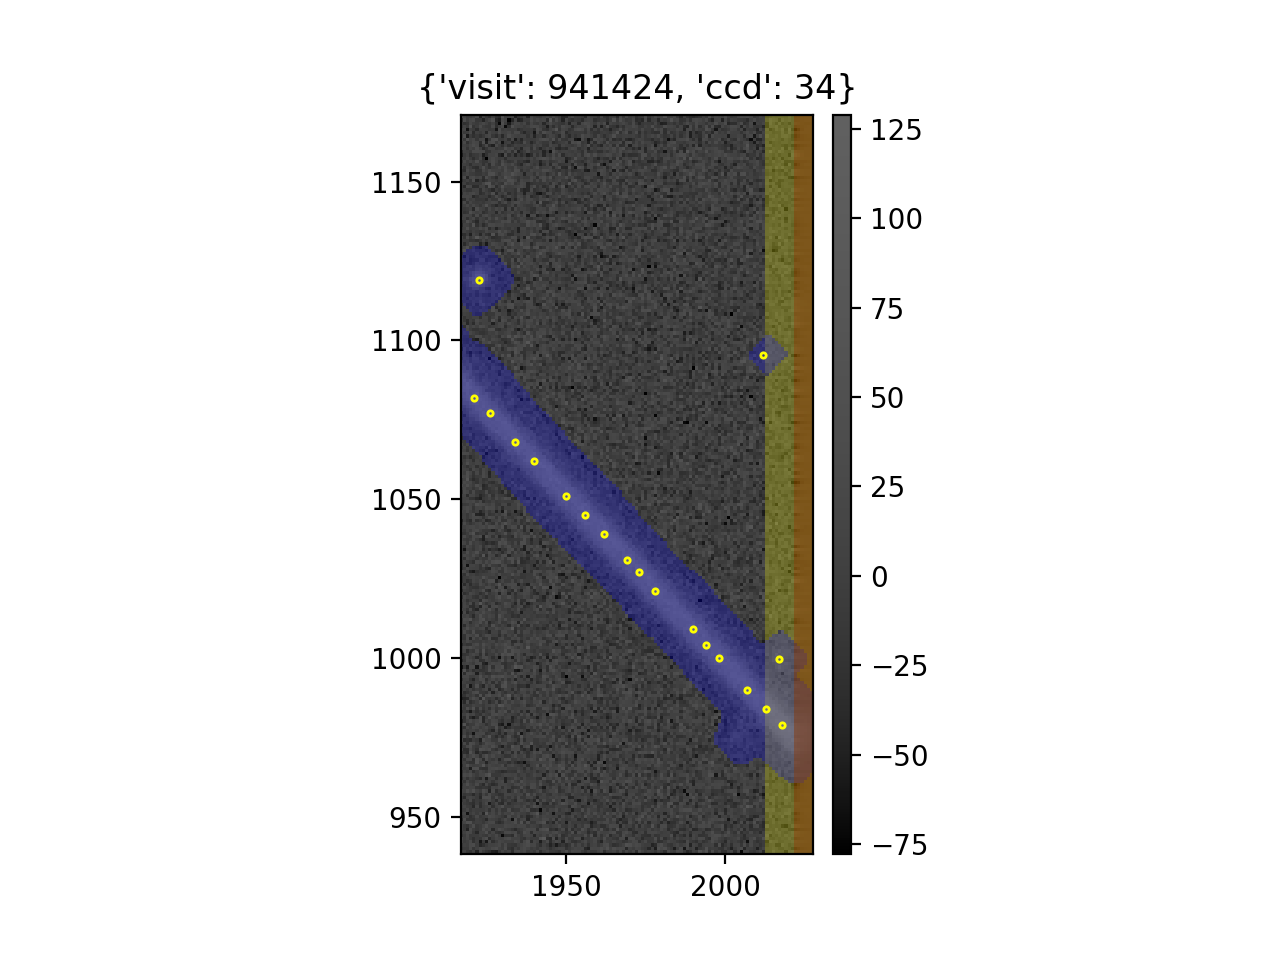

<IPython.core.display.Javascript object>


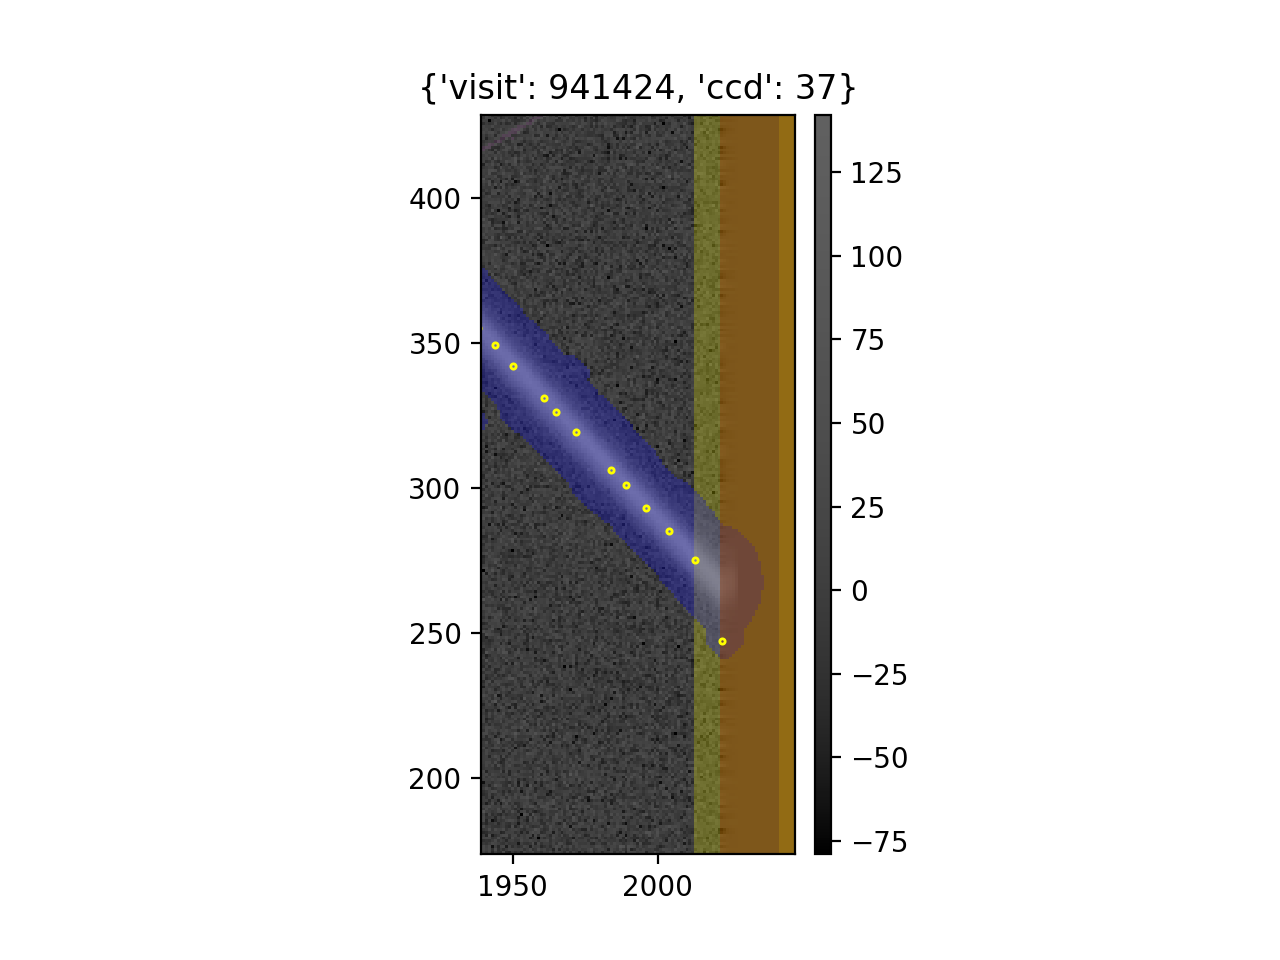

In [18]:
dataId1 = {'visit': 941424, 'ccd': 34}
dataId2 = {'visit': 941424, 'ccd': 37}

calexp1 = butler.get('calexp', dataId=dataId1)
src1 = butler.get('src', dataId=dataId1)
psfRadius1 = calexp1.getPsf().computeShape().getDeterminantRadius()
disp1 = afwDisplay.Display(31)
disp1.scale("asinh", "zscale", Q=8)
disp1.mtv(calexp1, title=str(dataId1))
plt.plot(src1['slot_Centroid_x'], src1['slot_Centroid_y'], marker='o',
         mfc='None', ls='None', ms=psfRadius1, color='yellow')

calexp2 = butler.get('calexp', dataId=dataId2)
src2 = butler.get('src', dataId=dataId2)
psfRadius2 = calexp2.getPsf().computeShape().getDeterminantRadius()
disp2 = afwDisplay.Display(32)
disp2.scale("asinh", "zscale", Q=8)
disp2.mtv(calexp2, title=str(dataId2))
plt.plot(src2['slot_Centroid_x'], src2['slot_Centroid_y'], marker='o',
         mfc='None', ls='None', ms=psfRadius2, color='yellow')

In [28]:
trail1Point1 = [83.5, 3030.5]
trail1Point2 = [1986.9, 1012.5]

trail2Point1 = [67.3, 2343.2]
trail2Point2 = [1978.1, 312.0]

<IPython.core.display.Javascript object>


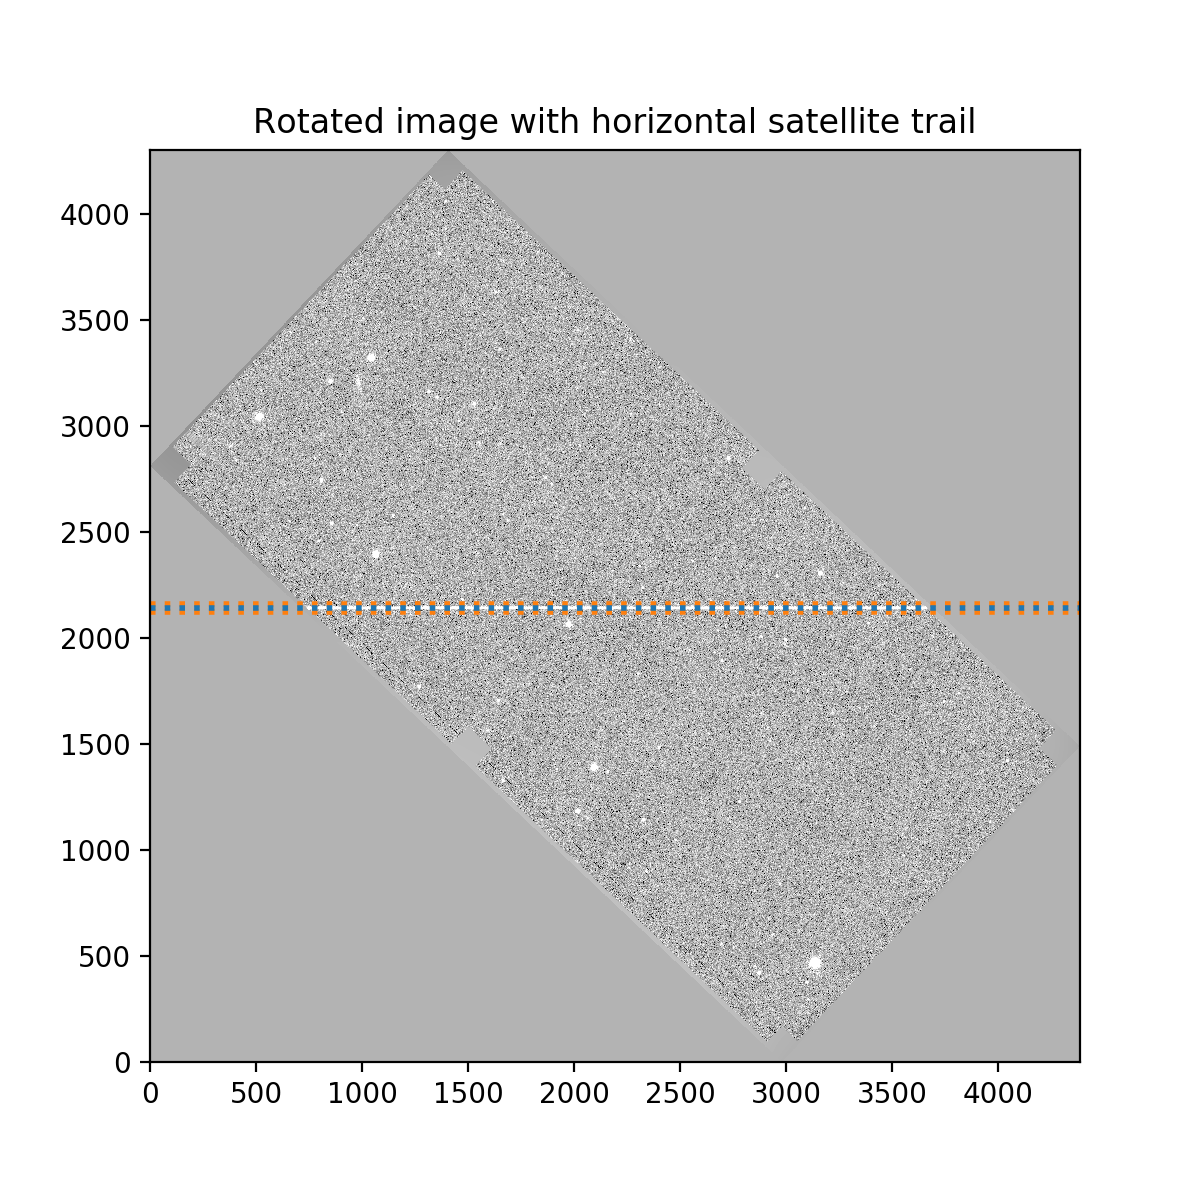

<IPython.core.display.Javascript object>


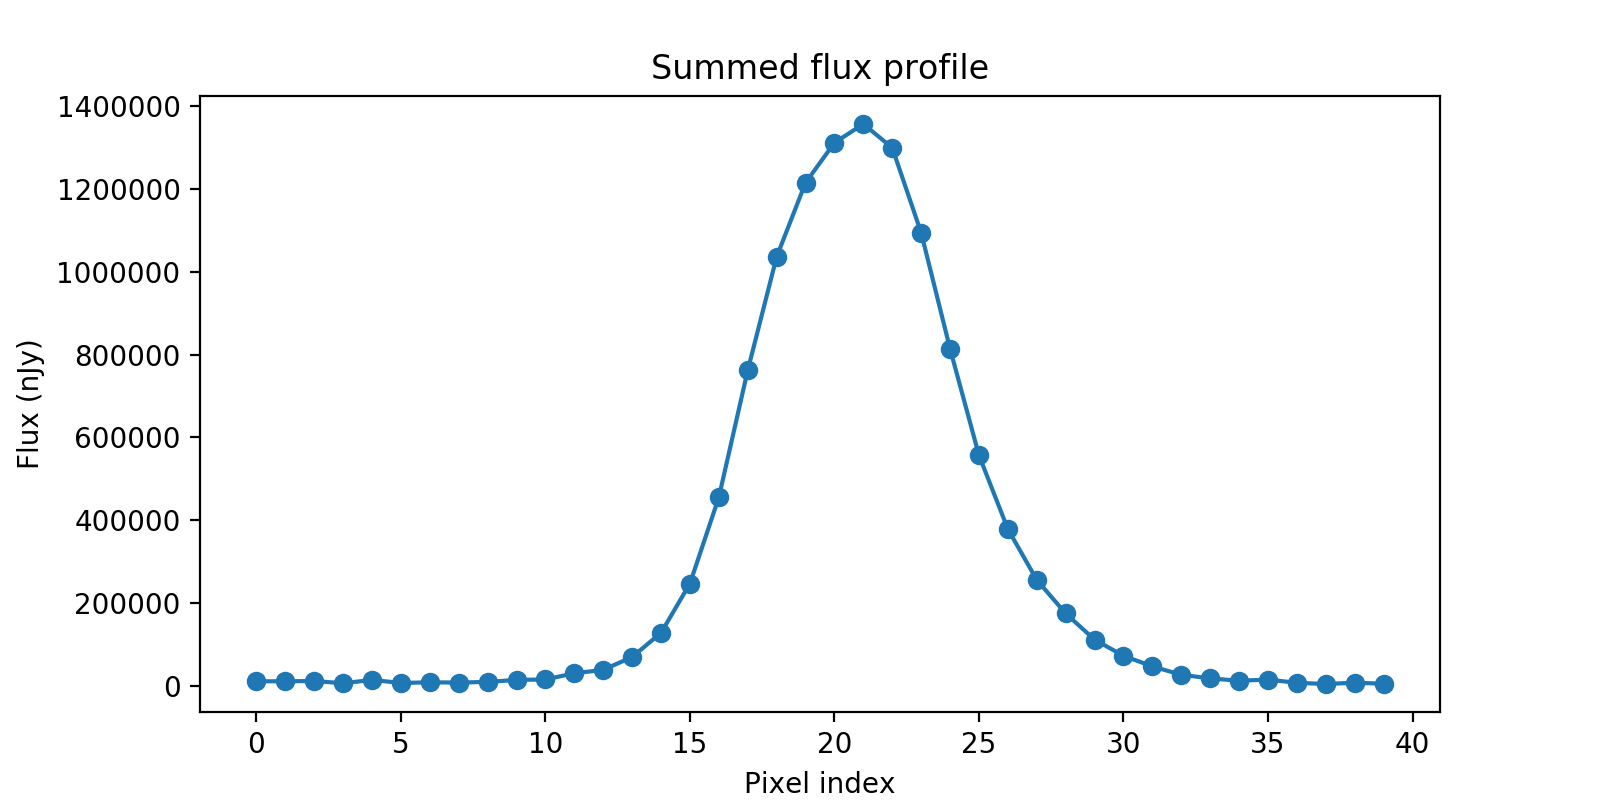

<IPython.core.display.Javascript object>


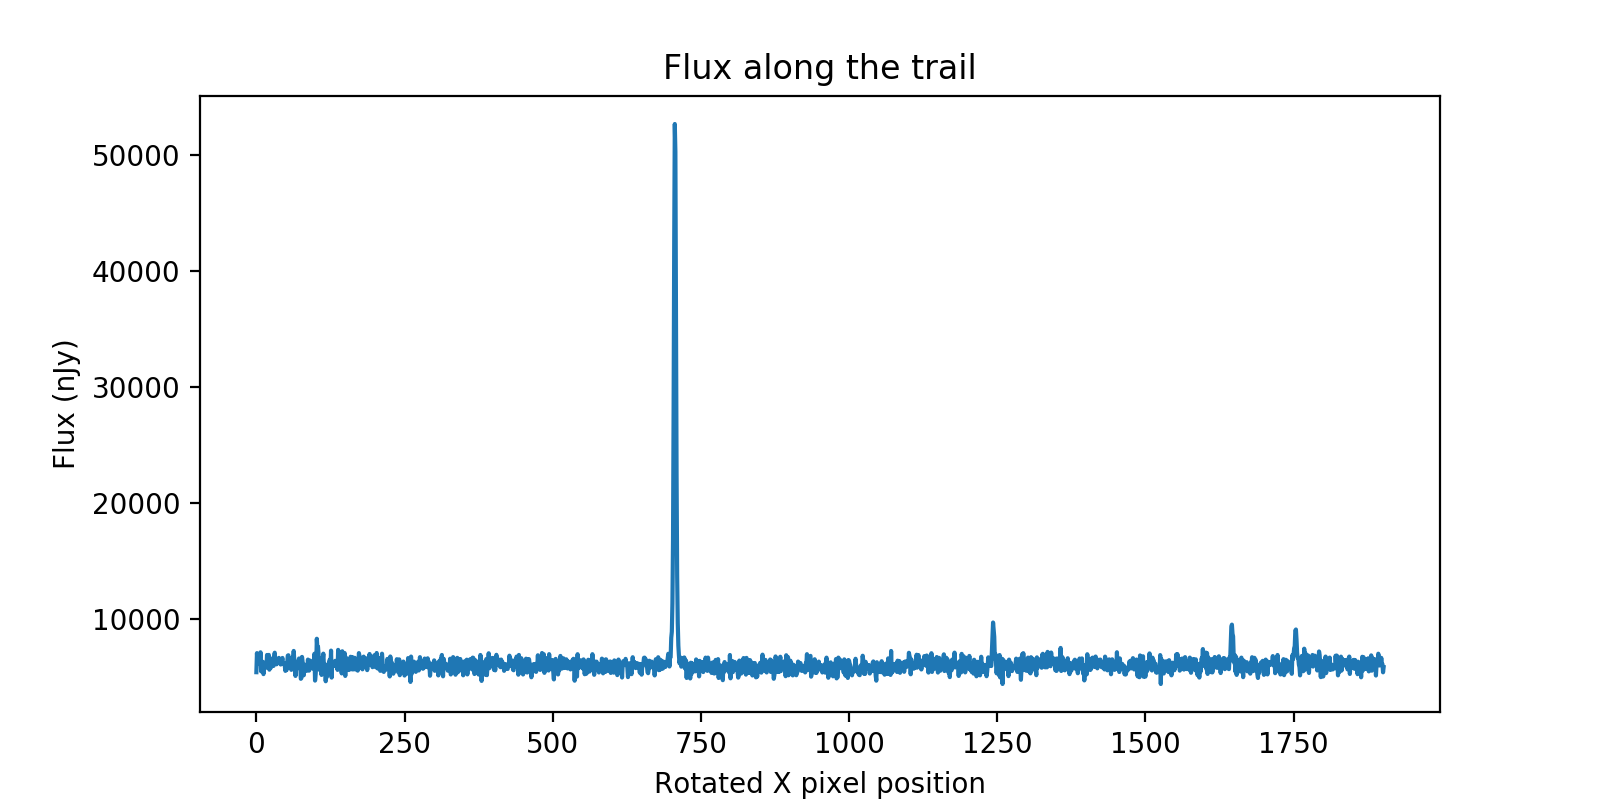

In [26]:
results = starlinkAnalyze(repo, dataId1, trail1Point1, trail1Point2, nudge=25)

<IPython.core.display.Javascript object>


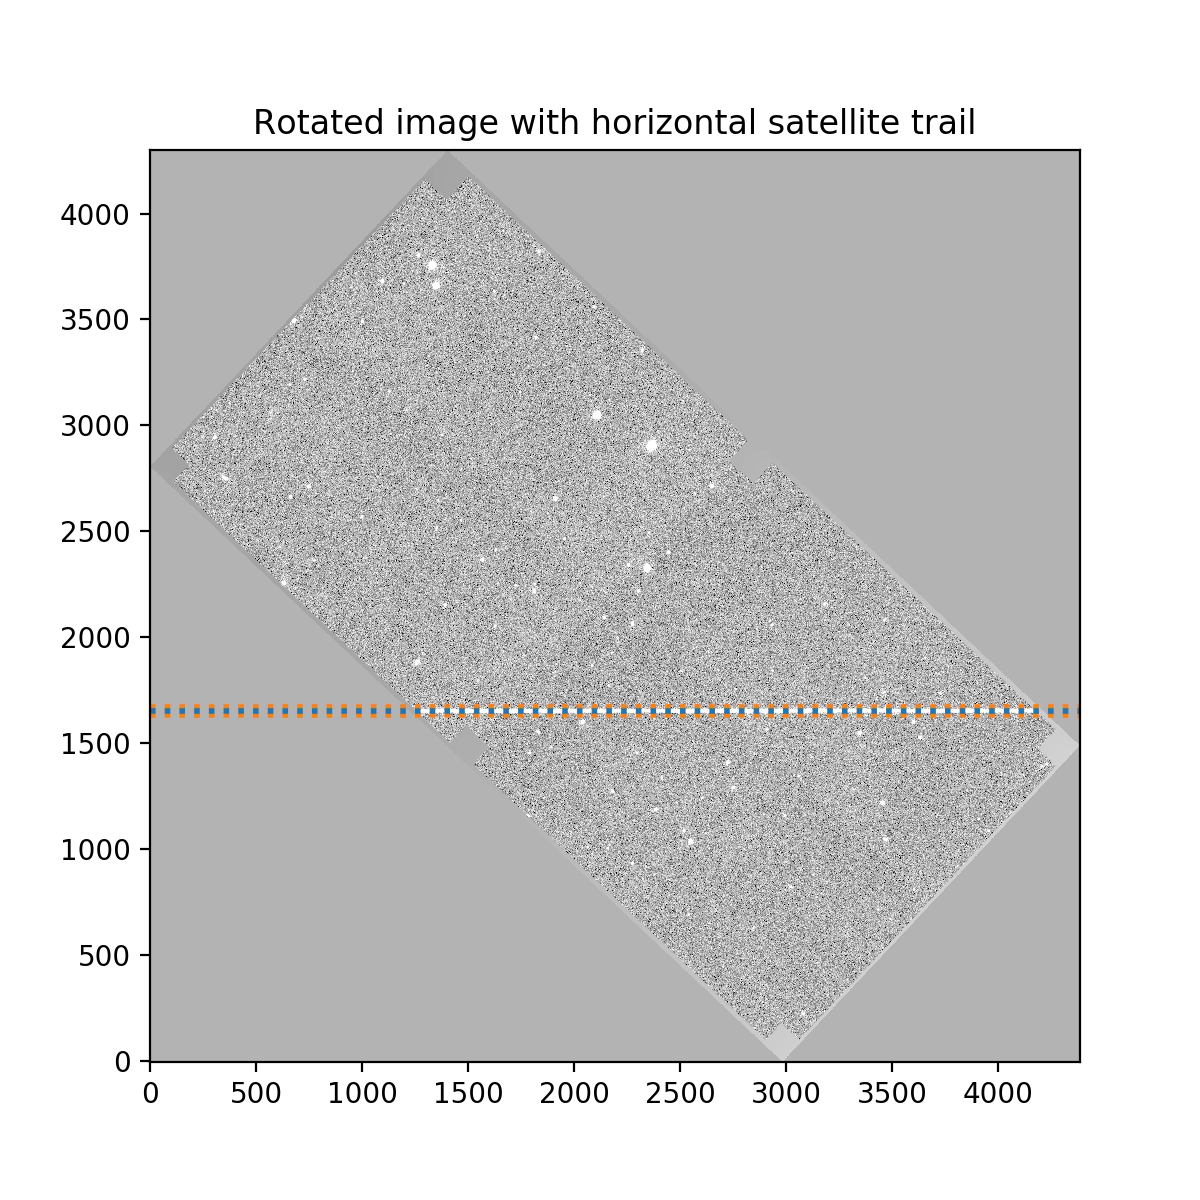

<IPython.core.display.Javascript object>


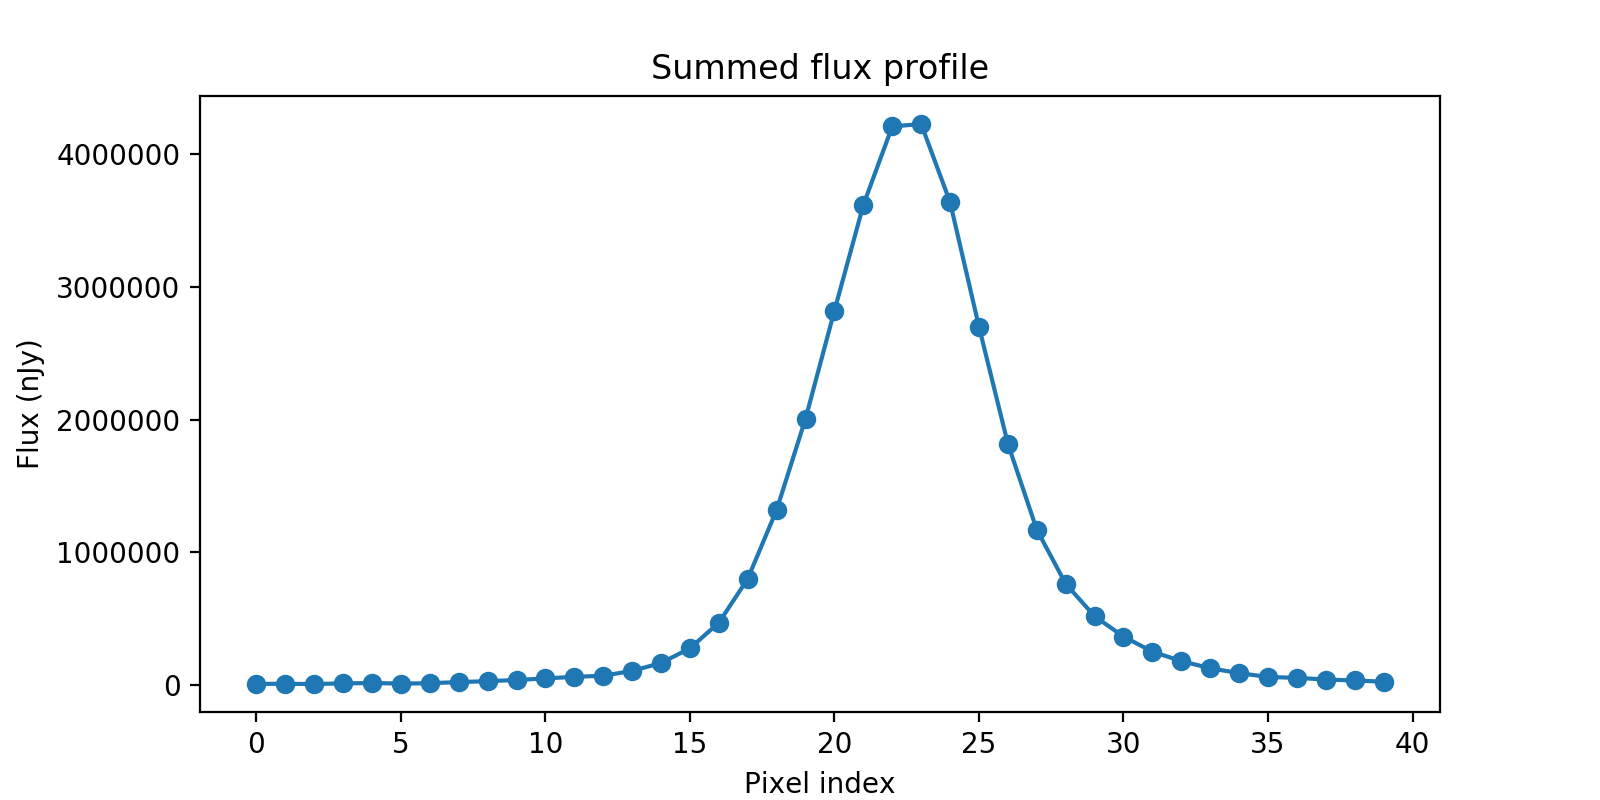

<IPython.core.display.Javascript object>


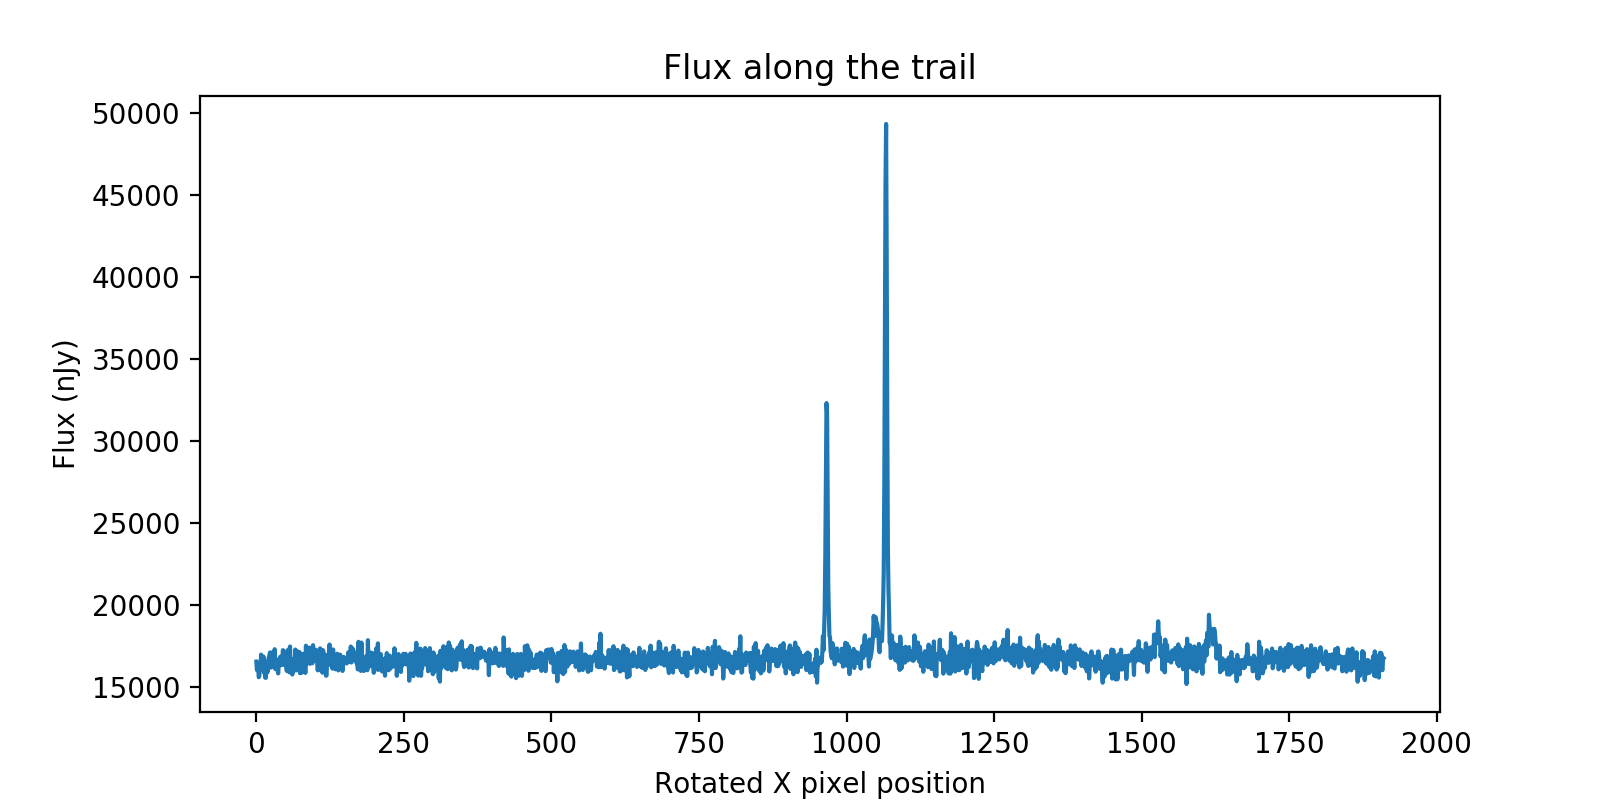

In [34]:
results = starlinkAnalyze(repo, dataId2, trail2Point1, trail2Point2, nudge=-940)